In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

In [2]:
# Define stock tickers
tickers = ['SPY', 'AAPL', 'GS', 'WMT', 'JNJ', 'NVDA', 'AMZN', 'NFLX', 'TSLA']

# # Calculate the last 252 business days
# end_date = datetime.now()
# business_days = pd.date_range(end=end_date, periods=252, freq='B')
# start_date = business_days[0]

# # Download stock data
# data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

# # Save to CSV file
# output_file = 'stock_data_252.csv'
# data.to_csv(output_file)

# print(f"Stock data for {tickers} saved to {output_file}")

In [3]:
# Creates dict which allows one to access the dataframe (value) for the corresponding ticker (key)
datasets = {tick:pd.read_csv(f'{tick}.csv') for tick in tickers}

In [4]:
close = np.array([datasets[tick]['adjClose'].values.tolist() for tick in tickers]).T

In [5]:
print(close)

[[422.425    173.37     300.86     ... 125.695    400.5      212.4199  ]
 [426.43     175.46     299.19     ... 128.4      401.77     220.11    ]
 [430.21     175.84     301.96     ... 128.13     346.19     242.68    ]
 ...
 [375.22     124.49     335.94     ...  83.12     309.700012 110.34    ]
 [379.55     125.82     339.79     ...  85.14     309.410004 113.64    ]
 [376.64     124.54     338.34     ...  85.82     294.950012 108.1     ]]


In [6]:
log_return = np.log(close[:-1]/close[1:])

In [7]:
rate_of_return = np.exp(log_return) - 1

In [8]:
rate_of_return.T

array([[-0.00939193, -0.00878641, -0.01332508, ...,  0.02291989,
        -0.01140825,  0.00772621],
       [-0.01191155, -0.00216106, -0.00739486, ...,  0.0367901 ,
        -0.01057066,  0.01027782],
       [ 0.00558174, -0.0091734 , -0.02392035, ...,  0.01256177,
        -0.01133053,  0.00428563],
       ...,
       [-0.02106698,  0.00210723, -0.02540504, ...,  0.03561116,
        -0.02372563, -0.00792356],
       [-0.00316101,  0.16054768, -0.02679073, ...,  0.01888917,
         0.00093729,  0.04902523],
       [-0.03493753, -0.09300313, -0.04775358, ...,  0.02465108,
        -0.02903907,  0.05124884]])

In [9]:
X = rate_of_return.T
X0 = X[0]

In [10]:
np.cov(X[0], X[1])/np.cov(X[0], X[0])

array([[1.        , 1.13733586],
       [1.13733586, 2.41786716]])

In [11]:
def beta_coef(x, y):
  coef = np.cov(x, y)
  beat = coef[0][1]
  box = coef[0][0]
  return beat / box

In [12]:
def capital_asset_pricing_model(rf, rm, beta):
  return rf + beta * (rm - rf)

In [13]:
market_rate = np.exp(log_return.T[0].sum()) - 1
risk_free_rate = 0.055

In [14]:
beta_list, capm_list = [], []

In [15]:
for x in X:
  beta = beta_coef(X0, x)
  capm = capital_asset_pricing_model(risk_free_rate, market_rate, beta)
  beta_list.append(beta)
  capm_list.append(capm)

In [16]:
np.array(beta_list), np.array(capm_list)

(array([1.        , 1.13733586, 1.00523497, 0.39254888, 0.28717787,
        2.11065389, 1.58712787, 1.33642073, 2.29838903]),
 array([0.1215617 , 0.13070301, 0.12191015, 0.08112872, 0.07411505,
        0.19548872, 0.16064193, 0.14395444, 0.20798469]))

In [17]:
from scipy.optimize import minimize

def minimize_risk(beta, capm, target_return):
  """
  Calculates optimal weights for minimizing risk in the CAPM model.

  Parameters
  ----------
  beta: list or np.ndarray
      Beta values of each stock (measure of risk relative to the market).
  capm: list or np.ndarray
      Expected returns of each stock from the CAPM model.
  target_return: float
      Desired return of the portfolio.

  Returns
  -------
  w: np.ndarray
      Optimal weights for each stock in the portfolio.

  Raises
  ------
  ValueError
      If inputs are invalid or optimization fails.
  """
  # Convert inputs to NumPy arrays
  beta, capm = np.array(beta), np.array(capm)

  # Validate inputs
  if len(beta) != len(capm):
      raise ValueError("Length of beta and capm must be the same.")
  if target_return < min(capm) or target_return > max(capm):
      raise ValueError("Target return is outside the feasible range.")

  # Define objective function (minimize portfolio risk)
  def objective(w):
      return np.dot(w, beta)

  # Define constraints
  def target_return_constraint(w):
    return np.dot(w, capm) - target_return  # Portfolio return >= target return

  def weight_sum_constraint(w):
    return np.sum(w) - 1  # Weights sum to 1

  # Initial weights (equal allocation)
  initial_weights = np.ones(len(beta)) / len(beta)

  # Constraints
  constraints = [
      {'type': 'ineq', 'fun': target_return_constraint},  # Portfolio return constraint
      {'type': 'eq', 'fun': weight_sum_constraint}        # Fully invested constraint
  ]

  # Bounds for weights (non-negative weights)
  bounds = [(0, None) for _ in range(len(beta))]

  # Perform optimization
  result = minimize(objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

  # Check for success
  if not result.success:
    raise ValueError(f"Optimization failed: {result.message}")

  # Return optimized weights
  return result.x

In [18]:
def maximize_return(beta, capm, target_beta):
  """
  Calculates optimal weights for maximizing return in the CAPM model.

  Parameters
  ----------
  beta: list or np.ndarray
      Beta values of each stock (measure of risk relative to the market).
  capm: list or np.ndarray
      Expected returns of each stock from the CAPM model.
  target_beta: float
      Desired beta of the portfolio.

  Returns
  -------
  w: np.ndarray
      Optimal weights for each stock in the portfolio.

  Raises
  ------
  ValueError
      If inputs are invalid or optimization fails.
  """
  # Convert inputs to NumPy arrays
  beta, capm = np.array(beta), np.array(capm)

  # Validate inputs
  if len(beta) != len(capm):
      raise ValueError("Length of beta and capm must be the same.")
  if target_beta < min(beta) or target_beta > max(beta):
      raise ValueError("Target beta is outside the feasible range.")

  # Define objective function (maximize portfolio beta)
  def objective(w):
      return - np.dot(w, capm)

  # Define constraints
  def target_beta_constraint(w):
    return - (np.dot(w, beta) - target_beta)  # Portfolio beta =< target beta

  def weight_sum_constraint(w):
    return np.sum(w) - 1  # Weights sum to 1

  # Initial weights (equal allocation)
  initial_weights = np.ones(len(beta)) / len(beta)

  # Constraints
  constraints = [
      {'type': 'ineq', 'fun': target_beta_constraint},  # Portfolio beta constraint
      {'type': 'eq', 'fun': weight_sum_constraint}        # Fully invested constraint
  ]

  # Bounds for weights (non-negative weights)
  bounds = [(0, None) for _ in range(len(beta))]

  # Perform optimization
  result = minimize(objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

  # Check for success
  if not result.success:
    raise ValueError(f"Optimization failed: {result.message}")

  # Return optimized weights
  return result.x

In [19]:
w_min_risk = minimize_risk(beta_list, capm_list, 0.13)
total = 0
for t, w in zip(tickers, w_min_risk):
  total += w
  print(t, w)
print('Total', total)

SPY 0.11829016939741219
AAPL 0.1141723359078104
GS 0.11813320755029538
WMT 0.13650376012453355
JNJ 0.1396631865867278
NVDA 0.0849886942930905
AMZN 0.10068591925575712
NFLX 0.10820302603843931
TSLA 0.07935970084593366
Total 1.0


In [20]:
minrisk, maxretn = minimize_risk(beta_list, capm_list, 0.13), maximize_return(beta_list, capm_list, 1.25)

In [21]:
total1 = 0
total2 = 0
for t, wrn, wrt, in zip(tickers, minrisk, maxretn):
  total1 += wrn
  total2 += wrt
  print(t, wrn, wrt)
print('Total', total1, total2)

SPY 0.11829016939741219 0.1104376813712189
AAPL 0.1141723359078104 0.11082395407863133
GS 0.11813320755029538 0.11045240544796073
WMT 0.13650376012453355 0.10872915456986594
JNJ 0.1396631865867278 0.10843278778067747
NVDA 0.0849886942930905 0.11356152188268483
AMZN 0.10068591925575712 0.11208904502222083
NFLX 0.10820302603843931 0.11138390190376365
TSLA 0.07935970084593366 0.11408954794297627
Total 1.0 1.0


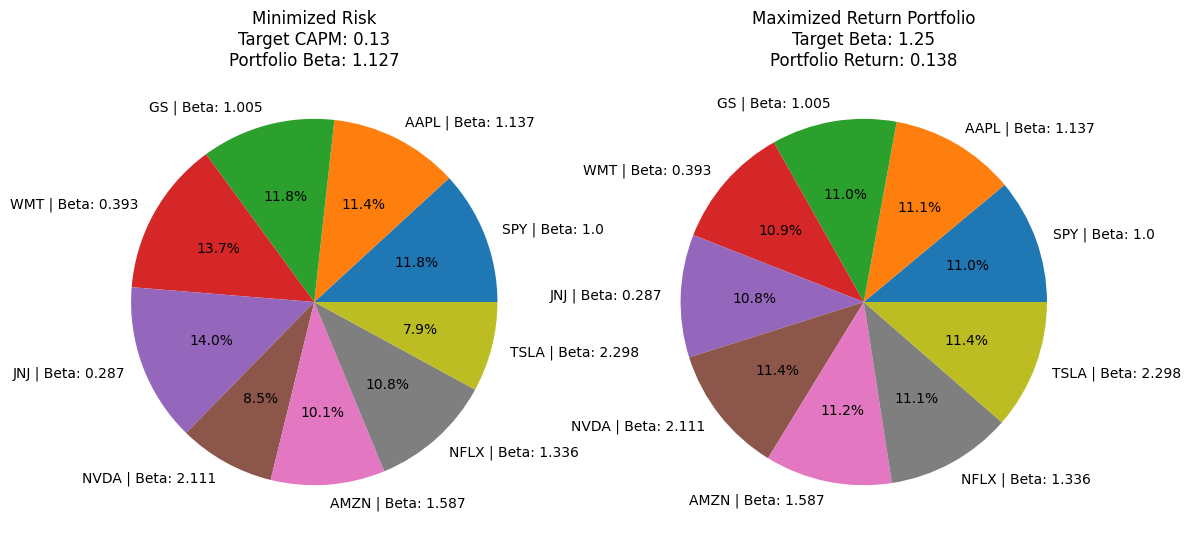

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), subplot_kw=dict(aspect="equal"))

target_return = 0.13
target_beta = 1.25

# Computes beta of minimized risk portfolio
minimized_risk = np.dot(minrisk, np.array(beta_list))

# Computes returns maximized returns portfolio
maximized_return = np.dot(maxretn, np.array(capm_list))

title1 = f'Minimized Risk\nTarget CAPM: {target_return}\nPortfolio Beta: {round(minimized_risk, 3)}'
axs[0].set_title(title1)

title2 = f'Maximized Return Portfolio\nTarget Beta: {target_beta}\nPortfolio Return: {round(maximized_return, 3)}'
axs[1].set_title(title2)

s_tickers = [f'{i} | Beta: {round(j,3)}' for i, j in zip(tickers, beta_list)]

axs[0].pie(minrisk, labels=s_tickers, autopct='%1.1f%%')
axs[1].pie(maxretn, labels=s_tickers, autopct='%1.1f%%');

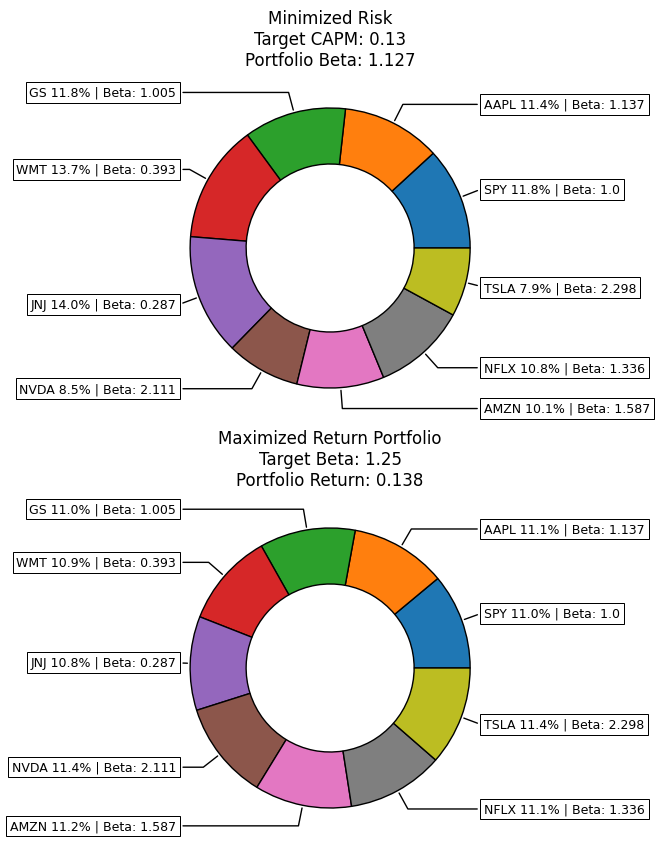

In [156]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), subplot_kw=dict(aspect="equal"))

# Weights of minimized risk portfolio
minrisk_list = minrisk.tolist()

# Weights of maximized returns portfolio
maxretn_list = maxretn.tolist()

target_return = 0.13
target_beta = 1.25

# Computes beta of minimized risk portfolio
minimized_risk = np.dot(minrisk, np.array(beta_list))

# Computes returns maximized returns portfolio
maximized_return = np.dot(maxretn, np.array(capm_list))

# Define titles
title1 = f'Minimized Risk\nTarget CAPM: {target_return}\nPortfolio Beta: {round(minimized_risk, 3)}'
axs[0].set_title(title1)

title2 = f'Maximized Return Portfolio\nTarget Beta: {target_beta}\nPortfolio Return: {round(maximized_return, 3)}'
axs[1].set_title(title2)

# Returns wedges objects representing the slices, and the text labels associated with the wedges (unused in this case)
wedges1, texts1 = axs[0].pie(minrisk, wedgeprops=dict(width=0.4, edgecolor="black"))
wedges2, texts2 = axs[1].pie(maxretn, wedgeprops=dict(width=0.4, edgecolor="black"))

# Defines properties of the text boxes
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)

# Dictionary for arrow and box properties
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges1):
  ang = (p.theta2 - p.theta1)/2. + p.theta1
  y = np.sin(np.deg2rad(ang))
  x = np.cos(np.deg2rad(ang))
  horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))] # Ensures text align with the side it appears
  connectionstyle = f"angle,angleA=0,angleB={ang}"
  kw["arrowprops"].update({"connectionstyle": connectionstyle})
  axs[0].annotate(f'{tickers[i]} {minrisk_list[i] * 100:.1f}% | Beta: {beta_list[i].round(3)}', xy=(x, y), xytext=(1.1*np.sign(x), 1.15*y),
              horizontalalignment=horizontalalignment, **kw, fontsize=9)

for i, p in enumerate(wedges2):
  ang = (p.theta2 - p.theta1)/2. + p.theta1
  y = np.sin(np.deg2rad(ang))
  x = np.cos(np.deg2rad(ang))
  horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))] # Ensures text align with the side it appears
  connectionstyle = f"angle,angleA=0,angleB={ang}"
  kw["arrowprops"].update({"connectionstyle": connectionstyle})
  axs[1].annotate(f'{tickers[i]} {maxretn_list[i] * 100:.1f}% | Beta: {beta_list[i].round(3)}', xy=(x, y), xytext=(1.1*np.sign(x), 1.15*y),
              horizontalalignment=horizontalalignment, **kw, fontsize=9)